# End-to-End Object Detection with Transformers (DETR) Code Review

Date : 22/3/10 

Presenter : Yukyung Lee

* Reference : https://github.com/facebookresearch/detr (official repo)
    * DETR repo provides a colab notebook to use model easily (minimal implementation version)
    * The original colab notebook describes the file as follows
        : In this notebook we show a demo of DETR (Detection Transformer), with slight differences with the baseline model in the paper.We show how to define the model, load pretrained weights and visualize bounding box and class predictions.


### Contents of Code Review
#### 1. DETR Overview
#### 2. DETR Code Review
#### 3. Prediction with COCO Dataset
#### 4. Difference between DETR and ViT

### 1. DETR Overview

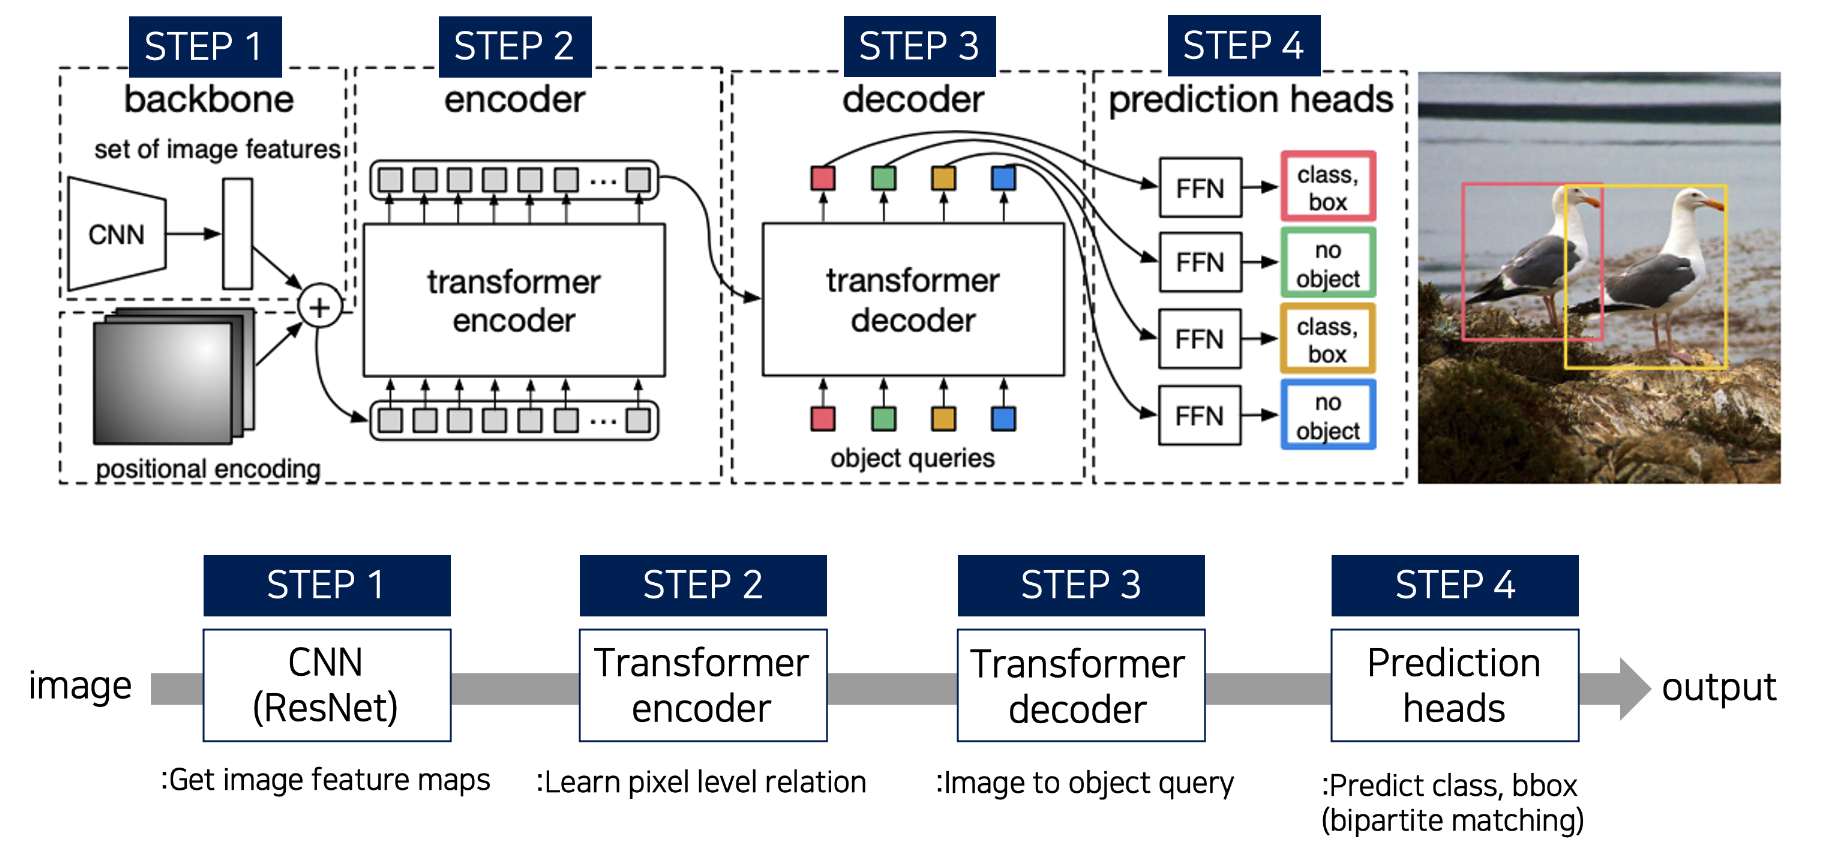

In [ ]:
from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(False);

%pip install einops -q
from einops import rearrange, repeat, reduce
from einops.layers.torch import Rearrange, Reduce
import torchvision.datasets as dset

### 2. DETR Code Review

In [ ]:
class DETRdemo(nn.Module):
    """
    Demo DETR implementation.

    Demo implementation of DETR in minimal number of lines, with the
    following differences wrt DETR in the paper:
    * learned positional encoding (instead of sine)
    * positional encoding is passed at input (instead of attention)
    * fc bbox predictor (instead of MLP)
    The model achieves ~40 AP on COCO val5k and runs at ~28 FPS on Tesla V100.
    Only batch size 1 supported.
    """
    def __init__(self, num_classes, hidden_dim=256, nheads=8,
                 num_encoder_layers=6, num_decoder_layers=6, log=False):
        super().__init__()
        self.log = log

        # create ResNet-50 backbone
        self.backbone = resnet50()
        del self.backbone.fc

        # To make image feature to transformer input sequence
        # dimensionality reduction: 2048 -> hidden dimension(256) , 1*1 Conv
        self.conv = nn.Conv2d(2048, hidden_dim, 1)

        # create a default PyTorch transformer (!= ViT)
        self.transformer = nn.Transformer(
            hidden_dim, nheads, num_encoder_layers, num_decoder_layers)

        # prediction heads
        # extra class for "no object", it is similiar role  to the "background" class
        # fixed size "num_classes" is usually much larger than the actual num of object 
        # note that in baseline DETR linear_bbox layer is 3-layer MLP
        self.linear_class = nn.Linear(hidden_dim, num_classes + 1)
        # to predict bounding box location : (Center X, Center Y, W, H)
        self.linear_bbox = nn.Linear(hidden_dim, 4)

        # output positional encodings (object queries)
        self.query_pos = nn.Parameter(torch.rand(100, hidden_dim))

        # spatial positional encodings
        # note that in baseline DETR use sine positional encodings
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))

    def forward(self, inputs):
        if self.log == True:
          print('input shape: ', inputs.shape)
        #######################################################
        # STEP1: Extract image features from backbone network #
        #######################################################

        # propagate inputs through ResNet-50 up to avg-pool layer
        x = self.backbone.conv1(inputs)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)
        if self.log == True:
          print('feature map output: ', x.shape)

        # convert from 2048 to 256 feature planes for the transformer
        h = self.conv(x)
        if self.log == True:
          print('Dimensionally reduction from 1*1 conv: ',h.shape)

        # construct positional encodings
        H, W = h.shape[-2:]

        if self.log == True:
          print('H shape: ',H)
          print('W shape: ',W)

        pos = torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)

        #######################################################
        #    STEP2,3,4: Pass Transformer model (Simple!)      #
        #######################################################
        # propagate through the transformer
        # change image feature map to sequence
        # self.transformer(src, tgt)

        if self.log == True:
          src = pos + 0.1 * h.flatten(2).permute(2, 0, 1)
          tgt = self.query_pos.unsqueeze(1)
          print('source input shape: ',src.shape)
          print('target output shape: ', tgt.shape)

        h = self.transformer(pos + 0.1 * h.flatten(2).permute(2, 0, 1),
                             self.query_pos.unsqueeze(1)).transpose(0, 1)
        if self.log == True:
          print('transformer output shape: ',h.shape)

        # finally project transformer outputs to class labels and bounding boxes
        return {'pred_logits': self.linear_class(h), 
                'pred_boxes': self.linear_bbox(h).sigmoid()}

In [ ]:
detr = DETRdemo(num_classes=91, hidden_dim=256, nheads=8, num_encoder_layers=6, num_decoder_layers=6, log=True)
detr.eval()
inputs = torch.randn(1,3,800,1200)
output = detr(inputs)


input shape:  torch.Size([1, 3, 800, 1200])
feature map output:  torch.Size([1, 2048, 25, 38])
Dimensionally reduction from 1*1 conv:  torch.Size([1, 256, 25, 38])
H shape:  25
W shape:  38
source input shape:  torch.Size([950, 1, 256])
target output shape:  torch.Size([100, 1, 256])
transformer output shape:  torch.Size([1, 100, 256])


In [ ]:
output['pred_logits']

tensor([[[ 1.0755,  0.6180, -0.1817,  ...,  0.1941, -0.2509,  1.3734],
         [ 1.0334,  0.6746, -0.1068,  ...,  0.2120, -0.3152,  1.3846],
         [ 1.0799,  0.6839, -0.1844,  ...,  0.2535, -0.2277,  1.3929],
         ...,
         [ 1.1189,  0.7121, -0.1073,  ...,  0.2760, -0.2796,  1.3990],
         [ 1.0354,  0.7350, -0.0792,  ...,  0.2993, -0.2529,  1.3578],
         [ 1.0690,  0.6678, -0.0771,  ...,  0.1818, -0.2859,  1.3495]]])

In [ ]:
output['pred_boxes']

tensor([[[0.7435, 0.6196, 0.4521, 0.4083],
         [0.7386, 0.6118, 0.4316, 0.4224],
         [0.7542, 0.6119, 0.4392, 0.4164],
         [0.7617, 0.6067, 0.4151, 0.4107],
         [0.7578, 0.6080, 0.4433, 0.4130],
         [0.7380, 0.5993, 0.4481, 0.4122],
         [0.7503, 0.5976, 0.4528, 0.4104],
         [0.7380, 0.6037, 0.4382, 0.4335],
         [0.7434, 0.5930, 0.4429, 0.4126],
         [0.7517, 0.5983, 0.4372, 0.4102],
         [0.7457, 0.6080, 0.4484, 0.4120],
         [0.7460, 0.6265, 0.4286, 0.4328],
         [0.7436, 0.6092, 0.4253, 0.4312],
         [0.7273, 0.6054, 0.4313, 0.4105],
         [0.7558, 0.5896, 0.4447, 0.4241],
         [0.7476, 0.5820, 0.4527, 0.4139],
         [0.7332, 0.6022, 0.4432, 0.4258],
         [0.7502, 0.5838, 0.4435, 0.4152],
         [0.7470, 0.5931, 0.4464, 0.4292],
         [0.7373, 0.6052, 0.4480, 0.4285],
         [0.7456, 0.6125, 0.4334, 0.4328],
         [0.7457, 0.5967, 0.4447, 0.4179],
         [0.7419, 0.5929, 0.4354, 0.4194],
         [0

### Prediction with COCO Dataset
* load pretrained DETR weight from torch hub (DETR requires a huge amount of computing resources to train.)
* The pre-trained DETR model has been trained on the 80 COCO classes, with class indices ranging from 1 to 90
* The reason why : input sequence - pixel level (my opinion)

In [ ]:
detr = DETRdemo(num_classes=91,log=False) # trained 80 COCO classes
state_dict = torch.hub.load_state_dict_from_url(
    url='https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth',
    map_location='cpu', check_hash=True)
detr.load_state_dict(state_dict)
detr.eval();

In [ ]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

* Original notebook's comment: 
  *DETR uses standard ImageNet normalization, and output boxes in relative image coordinates in $[x_{\text{center}}, y_{\text{center}}, w, h]$ format, where $[x_{\text{center}}, y_{\text{center}}]$ is the predicted center of the bounding box, and $w, h$ its width and height. Because the coordinates are relative to the image dimension and lies between $[0, 1]$, we convert predictions to absolute image coordinates and $[x_0, y_0, x_1, y_1]$ format for visualization purposes.*

In [ ]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [ ]:
def detect(im, model, transform):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0)

    # demo model only support by default images with aspect ratio between 0.5 and 2
    # if you want to use images with an aspect ratio outside this range
    # rescale your image so that the maximum size is at most 1333 for best results
    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'

    # propagate through the model
    outputs = model(img)

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.7

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
    return probas[keep], bboxes_scaled

####  DETR demo (examples from original notebook)

In [ ]:
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
im = Image.open(requests.get(url, stream=True).raw)

scores, boxes = detect(im, detr, transform)

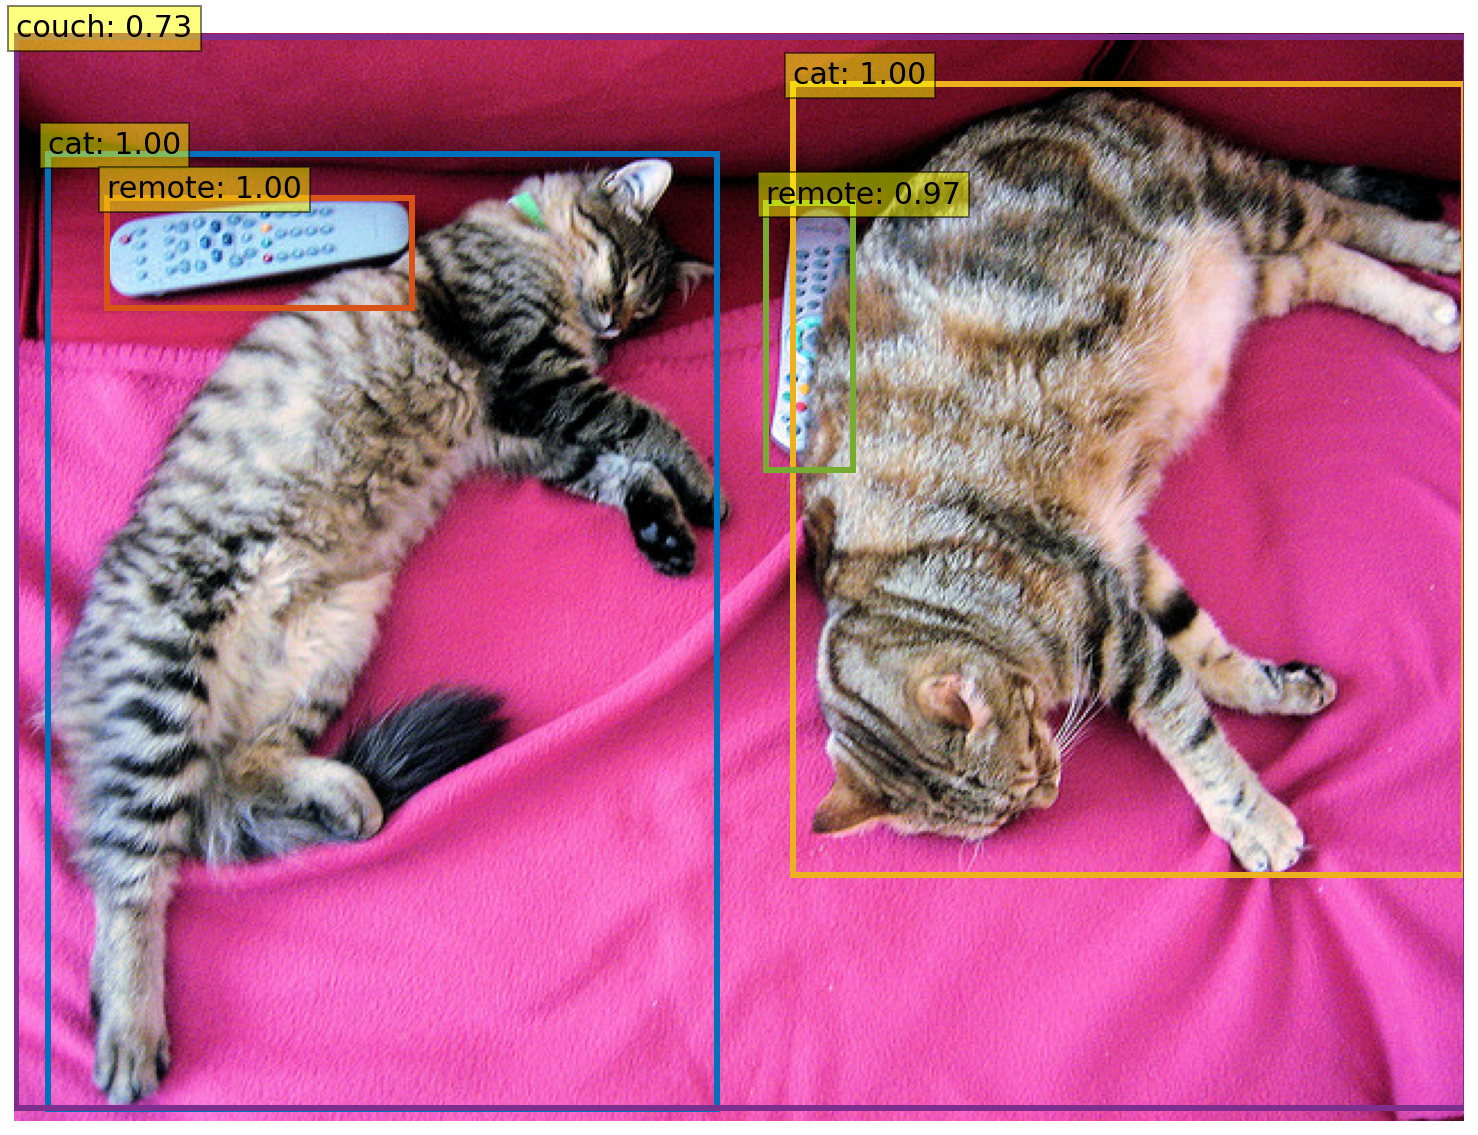

In [ ]:
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()
    
plot_results(im, scores, boxes)

### 4. Difference between DETR and ViT

* DETR and ViT are not fair comparison targets, but it is meaningful to look at the differences as a Transformer-based model
* The biggest difference between the two models is the input type (pixel level, patch level input)

In [ ]:
# ViT Image embedding

class image_embedding(nn.Module):
    def __init__(
        self,
        in_channels: int = 3,
        img_size: int = 224,
        patch_size: int = 16,
        emb_dim: int = 16 * 16 * 3,
    ):
        super().__init__()

        # Image to patch using einops library (In official code, they use 'torch.view' to make patch)
        # Rearrange image from (B,C,W,H) to (B, P^2*C, N)
        self.rearrange = Rearrange(
            "b c (num_w p1) (num_h p2) -> b (num_w num_h) (p1 p2 c) ",
            p1=patch_size,
            p2=patch_size,
        )
        # Linear projection (embedding)
        self.linear = nn.Linear(in_channels * patch_size * patch_size, emb_dim)
        # Class embedding tokens
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_dim))
        # N = H*W/P^2
        n_patches = img_size * img_size // patch_size ** 2
        # Position embedding, Dimension = (N+1)*D
        self.positions = nn.Parameter(torch.randn(n_patches + 1, emb_dim))

    def forward(self, x):
        batch, channel, width, height = x.shape

        x = self.rearrange(x)
        x = self.linear(x)

        # [cls token] ; image embedding
        c = repeat(self.cls_token, "() n d -> b n d", b=batch)
        x = torch.cat((c, x), dim=1)  # concatenate all embedding

        # Add Position embedding
        x = x + self.positions
        return x  # x == z_0


# example
transform = T.Compose([T.ToTensor()])

dataset = dset.MNIST("dataset", train=False, download=True, transform=transform)
x = dataset[1][0]
x = x.unsqueeze(0)

# check embedding size
emb = image_embedding(1, 28, 4, 4 * 4)(x)
emb.shape

torch.Size([1, 50, 16])

### Useful link

* https://github.com/huggingface/transformers/blob/198c335d219a5eb4d3f124fdd1ce1a9cd9f78a9b/src/transformers/models/detr/modeling_detr.py

* https://github.com/NielsRogge/Transformers-Tutorials

* http://dsba.korea.ac.kr/seminar/?mod=document&uid=1784

* https://huggingface.co/docs/transformers/model_doc/detr

